In [8]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import surfinBH
import matplotlib as mpl
import scipy.stats as st
from matplotlib.colors import LogNorm
from matplotlib import ticker
from numba import jit
from scipy.interpolate import interp1d
import matplotlib
matplotlib.matplotlib_fname()
fig_mm = 1/25.4 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
def logMean(a,b):
    return 10**((np.log10(a)+np.log10(b))/2)

def loadData(path):
    data = np.loadtxt(path)
    min_redsft = data[:,0]
    max_redsft = data[:,1]
    min_mass = data[:,2]
    max_mass = data[:,3]
    min_q = data[:,4]
    max_q = data[:,5]
    merger_data = data[:,6]
    
    center_z = (min_redsft+max_redsft)/2
    center_m = logMean(min_mass,max_mass)
    center_q = logMean(min_q, max_q)
    dic = {}

    dic['m'] = center_m
    dic['q'] = center_q
    dic['z_formation'] = center_z
    dic['N'] = merger_data
    return dic

def Fe(e):
    return (1-e**2)**(-7.0/2.0)*(1+73.0/24.0*e**2+37.0/96.0*e**4)

def calc_delay(dic, e, type, gamma):
    H = 18
    G = 4.300917270e-3 #pc/solar mass (km/s)^2
    c = 299792.458 #km/s
    pc = 1
    m = dic['m']
    q = dic['q']
    M9 = m/1e9
    sigma = (M9/0.309)**(1.0/4.38)*200 #km/s
    Mstar = (M9/0.49)**(1.0/1.16)*1e11 #solar mass
    Ms6 = Mstar/1e6
    if type == 'ellip':
        xx = 2.95*Ms6**0.596
        yy = 34.8*Ms6**0.399
        xx[yy>xx]=yy[yy>xx]
        Reff = xx*pc #pc
    else:
        Reff = 2.95*Ms6**0.596*pc #pc

    #print(gamma)
    r0=Reff/0.75*(2**(1/(3-gamma))-1)
    rinf = r0/((Mstar/(2*m))**(1/(3-gamma))-1)

    rhoinf = (3-gamma)*Mstar/(4*np.pi) *r0/rinf**gamma/(rinf+r0)**(4-gamma)

    a_c = (64*G*G*sigma *Fe(e) *m * m*q * m*(1+q)/5/c**5/H/rhoinf)**(1.0/5)

    t = sigma/G/H/rhoinf/a_c #Myr

    dic['tau_merger'] = t

def Hz(z, m, l):
    H0 = 73 *1e-6 #km/s/pc
    return H0*np.sqrt(m*(1+z)**3+l)

def look_back_time(z,m,l):
    H0 = 73 *1e-6 #km/s/pc
    a = np.sqrt(m*(1+z)**3+l)
    b = np.sqrt(l)
    return 1/(3*b)*(np.log((a-b)/(1-b))  + np.log( (1+b)/(a+b) ))/H0
    
def look_back2z(t,m,l):
    zz = np.linspace(0,10,1000)
    tt = look_back_time(zz,m,l)
    f = interp1d(tt,zz)
    z_m = np.ones(len(t))*-1
    z_m[t>0] = f(t[t>0])
    return z_m
def calc_delay_z(dic):
    Omega_m = 0.25
    Omega_k = 0
    Omega_lambda = 0.75
    z = dic['z_formation']
    t = dic['tau_merger']
    

    t_b = look_back_time(z,Omega_m,Omega_lambda) #binary formation look back time
    t_m = t_b - t #merger time
    

    z_m = look_back2z(t_m,Omega_m,Omega_lambda)
    dic['t_formation'] = t_b
    dic['z_merger'] = z_m



In [11]:
def SgrA_delay(e, type, gamma):
    H = 18
    G = 4.300917270e-3 #pc/solar mass (km/s)^2
    c = 299792.458 #km/s
    pc = 1
    m = 4.3e6*4.0/(1+4.0)/0.95 #~5% mass loss due to merger
    q = 0.25
    M9 = m/1e9
    sigma = (M9/0.309)**(1.0/4.38)*200 #km/s
    Mstar = (M9/0.49)**(1.0/1.16)*1e11 #solar mass
    Ms6 = Mstar/1e6
    if type == 'ellip':
        xx = 2.95*Ms6**0.596
        yy = 34.8*Ms6**0.399
        #xx[yy>xx]=yy[yy>xx]
        xx = max(xx,yy)
        Reff = xx*pc #pc
    else:
        Reff = 2.95*Ms6**0.596*pc #pc

    #print(gamma)
    r0=Reff/0.75*(2**(1/(3-gamma))-1)
    rinf = r0/((Mstar/(2*m))**(1/(3-gamma))-1)

    rhoinf = (3-gamma)*Mstar/(4*np.pi) *r0/rinf**gamma/(rinf+r0)**(4-gamma)

    a_c = (64*G*G*sigma *Fe(e) *m * m*q * m*(1+q)/5/c**5/H/rhoinf)**(1.0/5)

    t = sigma/G/H/rhoinf/a_c #Myr

    print(t)



SgrA_delay(0, 'spiral',0.5)

SgrA_delay(0, 'ellip',1)

SgrA_delay(0, 'spiral',1.5)

1047.1665640613821
6554.977007278548
166.73193888894647


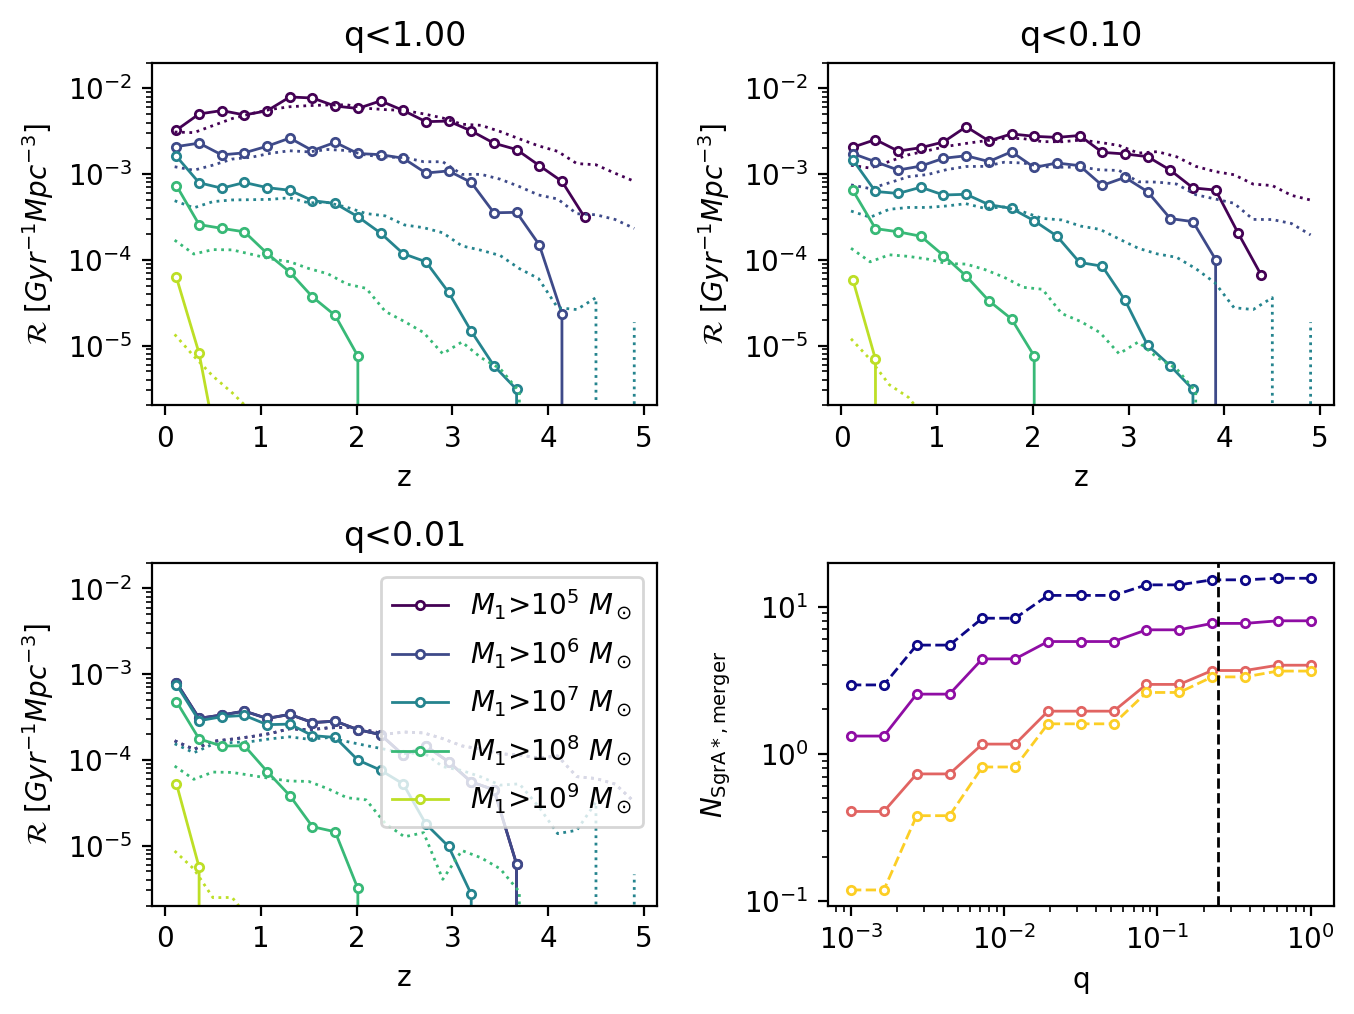

In [12]:
def paper_plot():
    dic = loadData('millenn.dat')
    calc_delay(dic, 0.67, 'spiral',1)
    calc_delay_z(dic)
    qs = [1,0.1,0.01]
    Ms = [1e5,1e6,1e7,1e8,1e9]
    colors = cm.viridis(np.linspace(0,0.9,len(Ms)))
    mag = 1.5
    fig = plt.figure(figsize=(88*fig_mm*2, 66*fig_mm*2))
    axs = [fig.add_subplot(2,2,i+1) for i in range(4)]
    for q,ax in zip(qs,axs):
        ax.set_title('q<%.2f'%q)
        for M, c in zip(Ms,colors):
            select = (dic['z_merger']>0) & (dic['m']>=M) & (dic['q']<q)
            zbin = np.linspace(0,4.5,20)
            x,y = np.histogram(dic['z_merger'][select],bins=zbin,weights=dic['N'][select])
            z = (y[:-1]+y[1:])/2
            dz = z[1]-z[0]
            dvdz = 4*np.pi *(299792.458)**3*look_back_time(z,0.25,0.75)**2/Hz(z,0.25,0.75)*(1e-6)**3
            rate = x/dz/dvdz
            ax.plot(z,rate*1e9,'-o',color=c,label=r'$M_1$>10$^{%d}$ $M_\odot$'%int(np.log10(M)),markersize=3,lw=1,mfc='w')
        

            select = (dic['z_formation']>0) & (dic['m']>=M)& (dic['q']<q)
            zbin = np.linspace(0,5,26)
            x,y = np.histogram(dic['z_formation'][select],bins=zbin,weights=dic['N'][select])
            z = (y[:-1]+y[1:])/2
            dz = z[1]-z[0]
            dvdz = 4*np.pi *(299792.458)**3*look_back_time(z,0.25,0.75)**2/Hz(z,0.25,0.75)*(1e-6)**3
            ax.plot(z,x/dz/dvdz*1e9,':',color=c,markersize=3,lw=1)

        ax.set_yscale('log')
        ax.set_xlabel('z')
        #if type == 'spiral':
        ax.set_ylim(2e-6,2e-2)
        #else:
         #   ax.set_ylim(6e-7,2e0)
        ax.set_ylabel(r'$\mathcal{R}$ [$Gyr^{-1}Mpc^{-3}$]')
    axs[2].legend()


    qs = np.logspace(-3,0,15)
    gammas = [0.5,1,1.5,2]
    #gammas = [1.5]
    colors = cm.plasma(np.linspace(0,0.9,len(gammas)))
    
    ax = axs[-1]
    for gamma, c  in zip(gammas, colors):
        dic = loadData('millenn.dat')
        calc_delay(dic, 0.67, type,gamma)
        calc_delay_z(dic)
        N = []
        for q in qs:
            M_tar = 4e6/(1+q)/0.95
            select = (dic['z_merger']>0)  & (dic['q']<=q) & (dic['m']>=M_tar)
            zbin = np.linspace(0,4.5,25)
            x,y = np.histogram(dic['z_merger'][select],bins=zbin,weights=dic['N'][select])
            z = (y[:-1]+y[1:])/2
            dz = z[1]-z[0]
            dvdz = 4*np.pi *(299792.458)**3*look_back_time(z,0.25,0.75)**2/Hz(z,0.25,0.75)*(1e-6)**3
            rate = x/dz/dvdz*1e9
            #print(M_tar, rate[0])
            N.append(rate[0]*30*13.8*10)
        if gamma == 0.5 or gamma == 2:
            ax.plot(qs,N,'--o',color=c,label=r'$\gamma_{\rm buldge}=%.1f$'%gamma,markersize=3,lw=1,mfc='w')
        else:
            ax.plot(qs,N,'-o',color=c,label=r'$\gamma_{\rm buldge}=%.1f$'%gamma,markersize=3,lw=1,mfc='w')

    ax.axvline(0.25,ls='--',color='k',lw=1,label='Gaia-Enceladus')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('q')
    #ax.set_ylabel(r'$\tau_{\rm Hubble}V_{\rm local}\mathcal{R}_{z=0} $')
    #ax.set_ylabel(r'$V_{\rm local}\int_0^{\tau_{\rm H}}\mathcal{R}(z)dt $')
    ax.set_ylabel(r'$N_{\rm SgrA*, merger}$')
    #ax.legend()
    plt.tight_layout()
    plt.savefig('rate.pdf',dpi=500,bbox_inches='tight')

paper_plot()